<a href="https://colab.research.google.com/github/peterruler/breast-cancer-cnn/blob/main/cnn_breastcancer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Mounted at /content/drive
Running dataset counting main function...
Detected Google Drive environment. Using root for datasets: /content/drive/My Drive/dl-udemy
Counting Google Drive images from root directory: /content/drive/My Drive/dl-udemy
Found 555097 images in /content/drive/My Drive/dl-udemy/breast-histopathology-images
Found 2893 images in /content/drive/My Drive/dl-udemy/MINI-DDSM-Complete-PNG-16/Benign/????
Found 3001 images in /content/drive/My Drive/dl-udemy/MINI-DDSM-Complete-PNG-16/Cancer/????
Found 9978 images in /content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/jpeg

Summary of counts per dataset:
- breast-histopathology-images: 555097
- MINI-DDSM-Complete-PNG-16: 5894
- cbis-ddsm-breast-cancer-image-dataset: 9978
---

Total images found across all datasets in Google Drive: 570969
Number of Images of no cancer: 198738
Number of Images of cancer : 78786
Total Number of Images : 277524


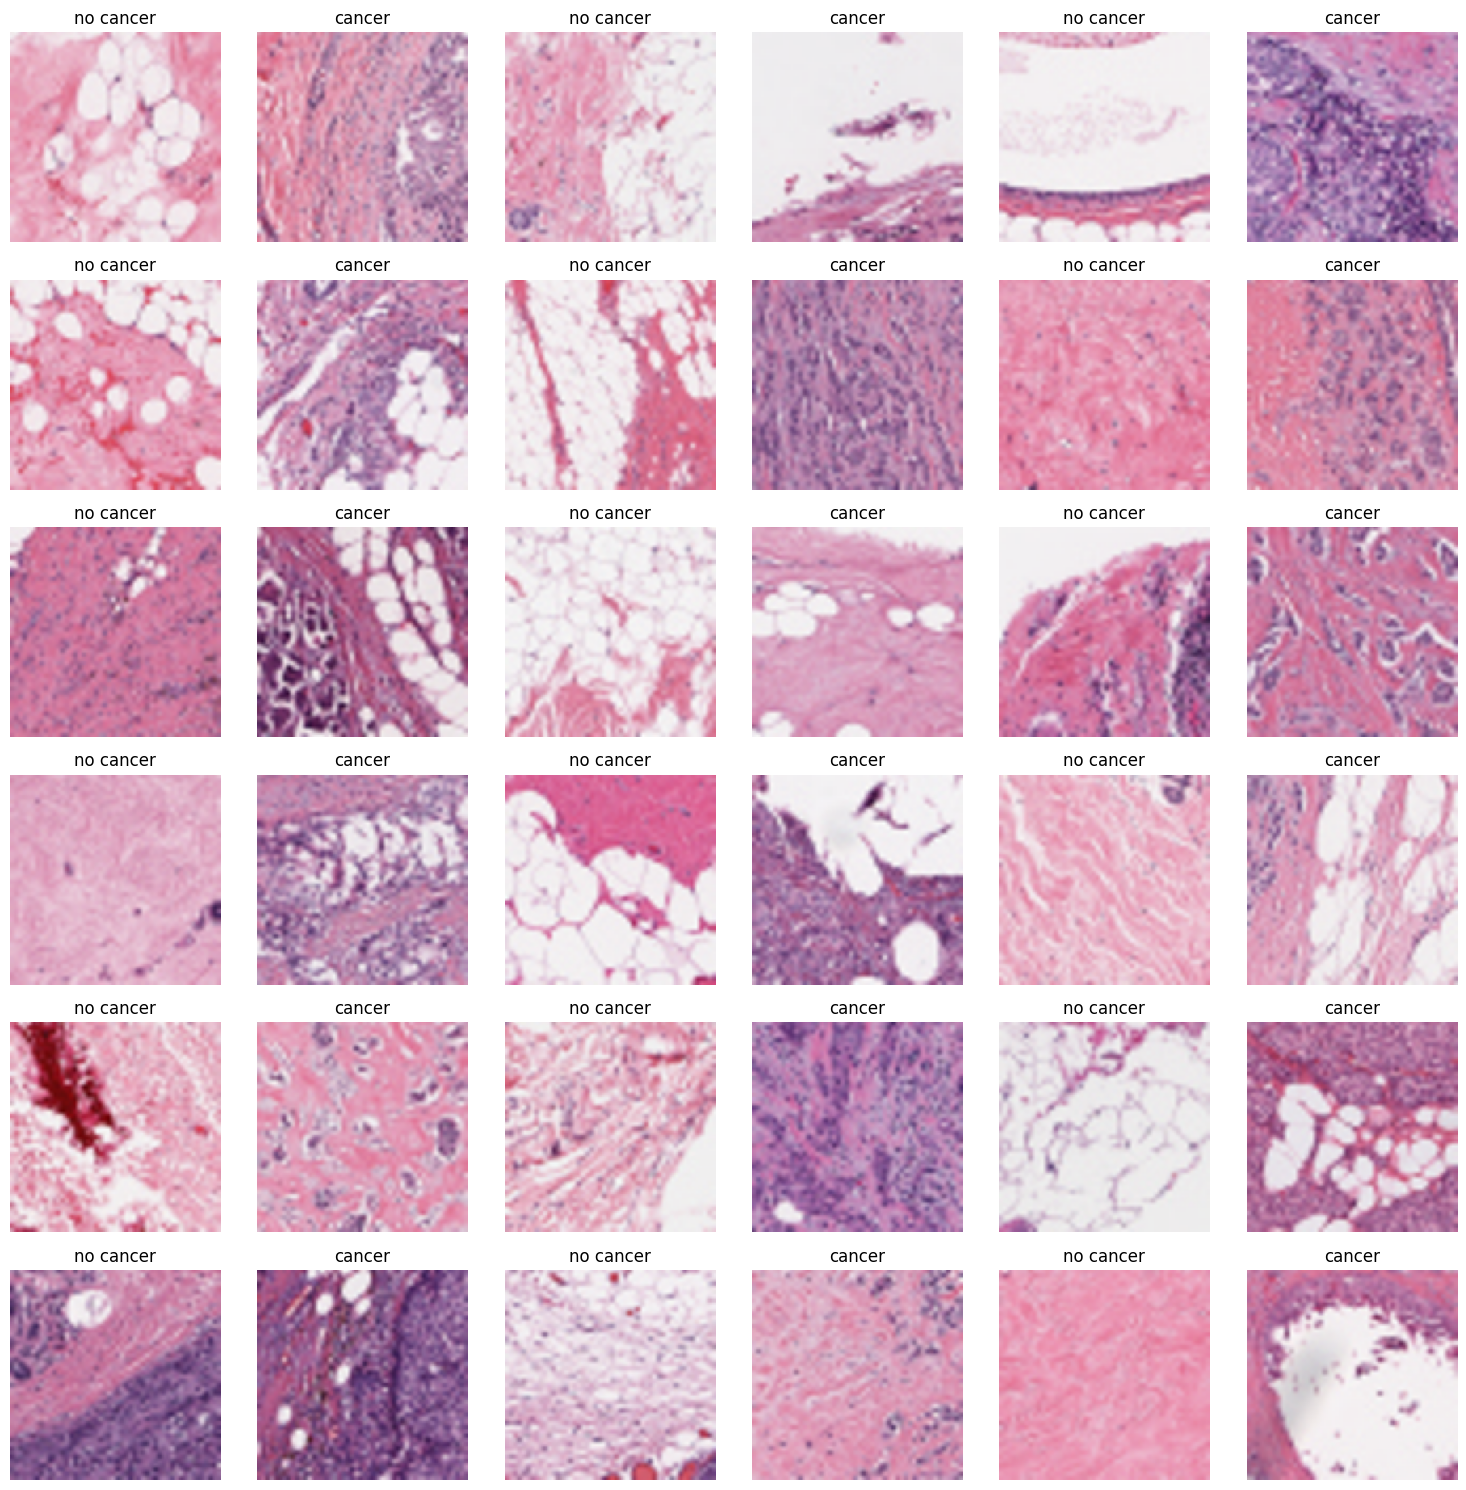

Using 15000 non-cancer images and 15000 cancer images.
X_train_np shape : (23998, 50, 50, 3)
X_test_np shape : (6000, 50, 50, 3)
y_train_np shape : (23998,)
y_test_np shape : (6000,)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25 - Loss: 0.4347, Acc: 0.8122 - Val Loss: 0.4675, Val Acc: 0.8032
Epoch 2/25 - Loss: 0.3930, Acc: 0.8327 - Val Loss: 0.4294, Val Acc: 0.8302
Epoch 3/25 - Loss: 0.3739, Acc: 0.8387 - Val Loss: 0.4327, Val Acc: 0.8215
EarlyStopping counter: 1 out of 5
Epoch 4/25 - Loss: 0.3650, Acc: 0.8482 - Val Loss: 0.4818, Val Acc: 0.8048
EarlyStopping counter: 2 out of 5
Epoch 5/25 - Loss: 0.3537, Acc: 0.8505 - Val Loss: 0.3526, Val Acc: 0.8478
Epoch 6/25 - Loss: 0.3426, Acc: 0.8569 - Val Loss: 0.3552, Val Acc: 0.8585
EarlyStopping counter: 1 out of 5
Epoch 7/25 - Loss: 0.3354, Acc: 0.8608 - Val Loss: 0.3921, Val Acc: 0.8412
EarlyStopping counter: 2 out of 5
Epoch 8/25 - Loss: 0.3240, Acc: 0.8657 - Val Loss: 0.3816, Val Acc: 0.8285
EarlyStopping counter: 3 out of 5
Epoch 9/25 - Loss: 0.2838, Acc: 0.8813 - Val Loss: 0.3279, Val Acc: 0.8612
Epoch 10/25 - Loss: 0.2613, Acc: 0.8903 - Val Loss: 0.3473, Val Acc: 0.8595
EarlyStopping counter: 1 out of 5
Epoch 11/25 - Loss: 0.2429, Acc: 0.8986 - Val

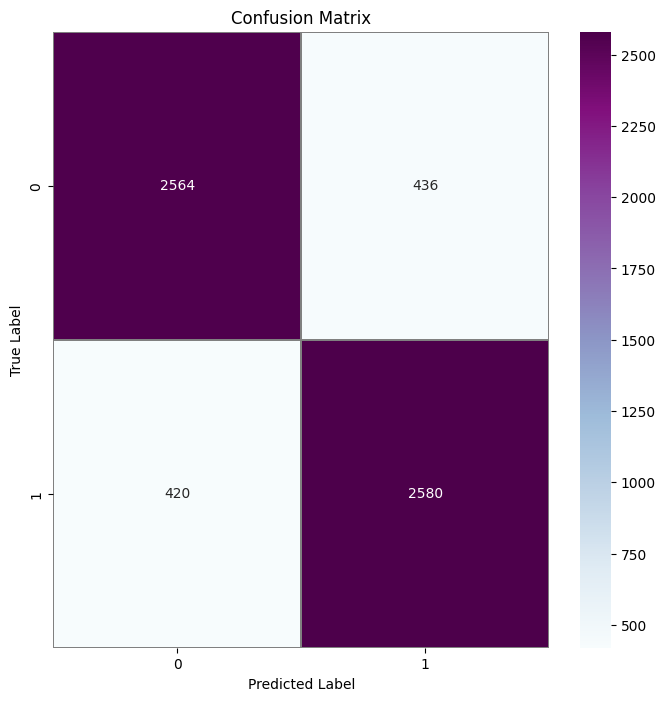

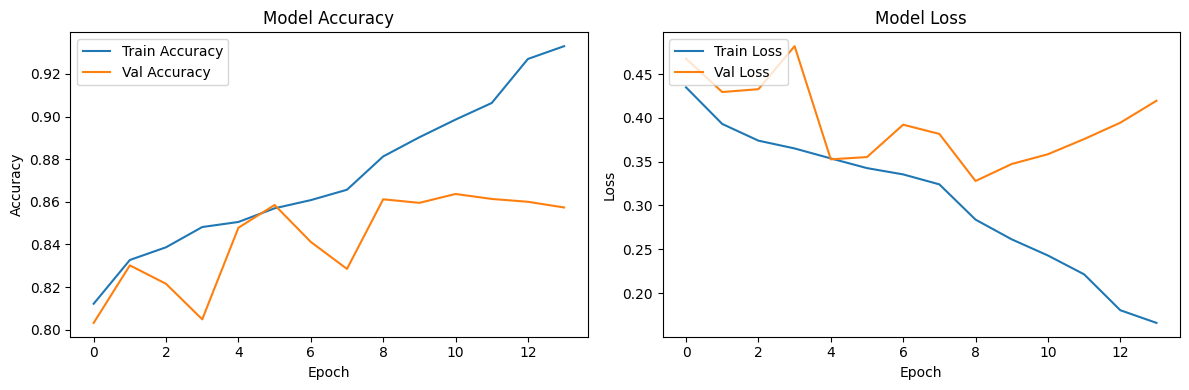


--- Single Image Test (Index: 90) ---
Predicted Diagnosis: Cancerous
Calcification Type (example): PLEOMORPHIC
True Diagnosis: Cancerous


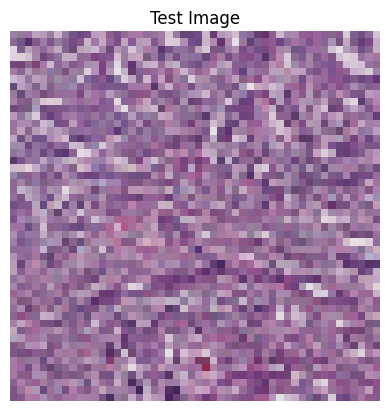

PyTorch model weights saved to CNN_model_pytorch_weights.pth
PyTorch model weights saved to Google Drive.


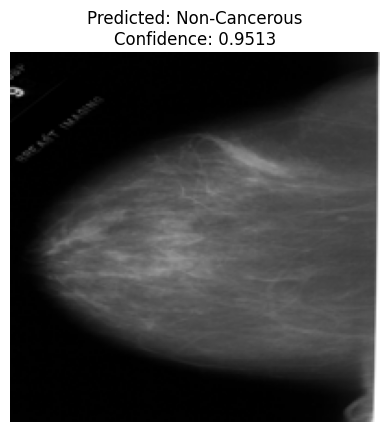

In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread # Keep, though PIL is more common with PyTorch
from PIL import Image # Added for consistency

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# from tensorflow.keras.utils import to_categorical # Replaced by direct use of class indices for PyTorch

import glob
# import PIL # Already imported as from PIL import Image
import random

# Seed for reproducibility
SEED = 100 # Original global seed
MODEL_SEED = 42 # Seed for model-specific parts

random.seed(SEED)
np.random.seed(SEED) # For numpy operations like train_test_split if it uses np.random
torch.manual_seed(MODEL_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(MODEL_SEED)
# tf.random.set_seed(MODEL_SEED) # Keras version

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

try:
    from google.colab import drive
    drive.mount('/content/drive')
    IS_COLAB = True
except ImportError:
    IS_COLAB = False
    print("Not running in Google Colab or drive mount failed.")


# --- Dataset Counting (No Keras/TF, should work as is) ---
# ... (The _count_dataset_images, count_images_local, count_images_gdrive, is_on_gdrive, main for counting functions remain unchanged)
# ... (I will omit them here for brevity but they are part of the final script)
def _count_dataset_images(root_path):
    total_count = 0
    counts_per_dataset = {}

    # 1. breast-histopathology-images
    dataset1_name = 'breast-histopathology-images'
    path1 = os.path.join(root_path, dataset1_name)
    current_dataset_count = 0
    if os.path.exists(path1):
        pattern1 = os.path.join(path1, '**', '*.png')
        files1 = glob.glob(pattern1, recursive=True)
        current_dataset_count = len(files1)
        print(f"Found {current_dataset_count} images in {path1}")
    else:
        print(f"Directory not found: {path1}")
    total_count += current_dataset_count
    counts_per_dataset[dataset1_name] = current_dataset_count

    # 2. MINI-DDSM-Complete-PNG-16
    dataset2_name = 'MINI-DDSM-Complete-PNG-16'
    path2_base = os.path.join(root_path, dataset2_name)
    current_dataset_count = 0
    if os.path.exists(path2_base):
        pattern2a = os.path.join(path2_base, 'Benign', '????', '*.png')
        files2a = glob.glob(pattern2a)
        current_dataset_count += len(files2a)
        print(f"Found {len(files2a)} images in {os.path.join(path2_base, 'Benign', '????')}")

        pattern2b = os.path.join(path2_base, 'Cancer', '????', '*.png')
        files2b = glob.glob(pattern2b)
        current_dataset_count += len(files2b)
        print(f"Found {len(files2b)} images in {os.path.join(path2_base, 'Cancer', '????')}")
    else:
        print(f"Directory not found: {path2_base}")
    total_count += current_dataset_count
    counts_per_dataset[dataset2_name] = current_dataset_count

    # 3. cbis-ddsm-breast-cancer-image-dataset
    dataset3_name = 'cbis-ddsm-breast-cancer-image-dataset'
    path3_base = os.path.join(root_path, dataset3_name, 'jpeg')
    current_dataset_count = 0
    if os.path.exists(path3_base):
        pattern3 = os.path.join(path3_base, '*', '*.jpg')
        files3 = glob.glob(pattern3)
        current_dataset_count = len(files3)
        print(f"Found {current_dataset_count} images in {path3_base}")
    else:
        print(f"Directory not found: {os.path.join(root_path, dataset3_name, 'jpeg')} (or {os.path.join(root_path, dataset3_name)} is missing)")
    total_count += current_dataset_count
    counts_per_dataset[dataset3_name] = current_dataset_count

    print("\nSummary of counts per dataset:")
    for name, count in counts_per_dataset.items():
        print(f"- {name}: {count}")
    print("---")
    return total_count

def count_images_local(root_dir):
    print(f"Counting local images from root directory: {root_dir}")
    return _count_dataset_images(root_dir)

def count_images_gdrive(root_dir):
    print(f"Counting Google Drive images from root directory: {root_dir}")
    return _count_dataset_images(root_dir)

def is_on_gdrive_env(): # Renamed to avoid conflict if original is_on_gdrive is used elsewhere
    return os.path.exists('/content/drive') or os.path.exists('/drive')


if IS_COLAB: # Assuming this main is for the counting part primarily
    print("Running dataset counting main function...")
    local_datasets_root = os.getcwd() # This might not be relevant if always running on Colab with GDrive
    gdrive_datasets_root = '/content/drive/My Drive/dl-udemy'

    if is_on_gdrive_env():
        print(f"Detected Google Drive environment. Using root for datasets: {gdrive_datasets_root}")
        if not os.path.exists(gdrive_datasets_root):
            print(f"Google Drive datasets root path not found: {gdrive_datasets_root}")
            print("Please ensure Google Drive is mounted and the path is correct.")
            count = 0
        else:
            count = count_images_gdrive(gdrive_datasets_root)
        print(f"\nTotal images found across all datasets in Google Drive: {count}")
    else:
        # This branch might be less likely if IS_COLAB is true and drive mounted successfully
        print(f"Google Drive not detected (or mount failed). Using local root for datasets: {local_datasets_root}")
        if not os.path.exists(local_datasets_root):
            print(f"Local datasets root path not found: {local_datasets_root}")
            print("Ensure the script is run from the correct directory or adjust 'local_datasets_root'.")
            count = 0
        else:
            count = count_images_local(local_datasets_root)
        print(f"\nTotal images found across all local datasets: {count}")
else: # Not on Colab, assume local execution
    print("Assuming local execution for dataset counting...")
    local_datasets_root = os.getcwd() # User needs to set this appropriately for their local setup
    print(f"Using local root for datasets: {local_datasets_root}")
    if not os.path.exists(local_datasets_root):
        print(f"Local datasets root path not found: {local_datasets_root}")
        count = 0
    else:
        count = count_images_local(local_datasets_root)
    print(f"\nTotal images found across all local datasets: {count}")


# --- Pandas EDA and Data Cleaning (No Keras/TF, should work as is) ---
# ... (All pandas operations: dicom_data, cropped_images, Data_cleaning_1, etc. remain unchanged)
# ... (I will omit them here for brevity but they are part of the final script)
if IS_COLAB: # These paths are GDrive specific
    base_path_csv = '/content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/csv'
    image_dir_cbis = '/content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/jpeg' # Renamed to avoid conflict
    csv_path = os.path.join(base_path_csv, 'dicom_info.csv')
    dicom_data = pd.read_csv(csv_path)

    # dicom_data.head()
    # dicom_data.info()

    cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
    cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir_cbis))
    # ... (image display loops using PIL and matplotlib remain largely unchanged)

    # Example of image display (original code had multiple loops, showing one as example)
    # for file_path_str in cropped_images[0:2]: # Display fewer for brevity
    #     if os.path.exists(file_path_str):
    #         img_display = Image.open(file_path_str).convert("L")
    #         plt.imshow(img_display, cmap='gray')
    #         plt.axis('off')
    #         plt.show()
    #     else:
    #         print(f"File not found for display: {file_path_str}")

    # calc_case_df = pd.read_csv('/content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
    # mass_case_df = pd.read_csv('/content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')

    # --- Data Cleaning (Pandas) ---
    # dicom_cleaned_data = dicom_data.copy()
    # ... (dicom_cleaned_data drop and fillna operations) ...
    # Data_cleaning_1 = calc_case_df.copy()
    # ... (Data_cleaning_1 rename and fillna operations) ...
    # Data_cleaning_2 = mass_case_df.copy()
    # ... (Data_cleaning_2 rename and fillna operations) ...

    # --- Data Visualization (Plotly, Seaborn) ---
    # (These parts using Plotly and Seaborn on pandas dataframes are unchanged)
    # breast_imgs_path_pattern = '/content/drive/My Drive/dl-udemy/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png'
    # breast_imgs = glob.glob(breast_imgs_path_pattern, recursive = True)
else:
    print("Skipping GDrive specific EDA and data loading due to non-Colab environment or GDrive mount issue.")
    breast_imgs = [] # Ensure breast_imgs is defined
    # Define dummy dataframes if they are used later in a non-colab context, or handle appropriately
    dicom_cleaned_data = pd.DataFrame()
    Data_cleaning_1 = pd.DataFrame()
    Data_cleaning_2 = pd.DataFrame()


# This part is GDrive dependent, so ensure breast_imgs is populated if running locally
# If breast_imgs is empty (e.g. local run without data path setup), this will be empty too.
if IS_COLAB and os.path.exists('/content/drive/My Drive/dl-udemy/breast-histopathology-images/'):
    breast_imgs_path_pattern = '/content/drive/My Drive/dl-udemy/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png'
    breast_imgs = glob.glob(breast_imgs_path_pattern, recursive = True)
    if not breast_imgs:
        print(f"Warning: No images found at {breast_imgs_path_pattern}. breast_imgs list is empty.")
        print("The rest of the script relying on these images might not work as expected.")
elif not IS_COLAB:
    print("Define 'breast_imgs_path_pattern' for local execution if you want to load these images.")
    # Example: breast_imgs_path_pattern = 'path/to/your/IDC_regular_ps50_idx5/**/*.png'
    # breast_imgs = glob.glob(breast_imgs_path_pattern, recursive=True) if 'breast_imgs_path_pattern' in locals() else []
    breast_imgs = [] # Default to empty if not set up for local

non_cancer_imgs = []
cancer_imgs = []

for img_path in breast_imgs:
    if img_path[-5] == '0' : # Checks the label from filename, e.g., "..._0.png"
        non_cancer_imgs.append(img_path)
    elif img_path[-5] == '1' : # e.g., "..._1.png"
        cancer_imgs.append(img_path)

non_cancer_num = len(non_cancer_imgs)
cancer_num = len(cancer_imgs)
total_img_num = non_cancer_num + cancer_num

print(f'Number of Images of no cancer: {non_cancer_num}')
print(f'Number of Images of cancer : {cancer_num}')
print(f'Total Number of Images : {total_img_num}')


# --- Data Visualization: Sample Images ---
# Original Keras code:
# import matplotlib.pyplot as plt
# import numpy as np
# from tensorflow.keras.preprocessing import image

# plt.figure(figsize=(15, 15))
# some_non = np.random.randint(0, len(non_cancer_imgs), 18)
# some_can = np.random.randint(0, len(cancer_imgs), 18)
# for i, num in enumerate(some_non):
#     img = image.load_img(non_cancer_imgs[num], target_size=(100, 100))
#     img = image.img_to_array(img)
#     plt.subplot(6, 6, 2*i + 1)
#     plt.imshow(img.astype('uint8'))
#     plt.title('no cancer')
#     plt.axis('off')
# for i, num in enumerate(some_can):
#     img = image.load_img(cancer_imgs[num], target_size=(100, 100))
#     img = image.img_to_array(img)
#     plt.subplot(6, 6, 2*i + 2)
#     plt.imshow(img.astype('uint8'))
#     plt.title('cancer')
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

# PyTorch equivalent (using PIL)
if non_cancer_num > 0 and cancer_num > 0 : # Check if images were loaded
    plt.figure(figsize=(15, 15))
    num_samples_to_show = min(18, non_cancer_num, cancer_num) # Ensure we don't request more samples than available

    if num_samples_to_show > 0:
        some_non_indices = np.random.choice(len(non_cancer_imgs), num_samples_to_show, replace=False)
        some_can_indices = np.random.choice(len(cancer_imgs), num_samples_to_show, replace=False)

        for i in range(num_samples_to_show):
            # Non-cancer
            img_path_non = non_cancer_imgs[some_non_indices[i]]
            img_non = Image.open(img_path_non).convert('RGB')
            img_non = img_non.resize((100, 100))
            img_non_arr = np.array(img_non)

            plt.subplot(6, 6, 2*i + 1) # Max 36 plots, so 18 pairs
            plt.imshow(img_non_arr) # PIL Image.open loads as uint8, np.array preserves it
            plt.title('no cancer')
            plt.axis('off')

            # Cancer
            img_path_can = cancer_imgs[some_can_indices[i]]
            img_can = Image.open(img_path_can).convert('RGB')
            img_can = img_can.resize((100, 100))
            img_can_arr = np.array(img_can)

            plt.subplot(6, 6, 2*i + 2)
            plt.imshow(img_can_arr)
            plt.title('cancer')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough images to display samples (or num_samples_to_show is 0).")

else:
    print("Skipping sample image display as no cancer/non-cancer images were loaded.")


# --- Data Modeling ---
IMG_SIZE = 50
NUM_IMAGES_PER_CLASS = 15000 # As in original

if non_cancer_num > 0 and cancer_num > 0:
    random.shuffle(non_cancer_imgs)
    random.shuffle(cancer_imgs)
    # Cap the number of images
    non_cancer_imgs_subset = non_cancer_imgs[:min(NUM_IMAGES_PER_CLASS, len(non_cancer_imgs))]
    cancer_imgs_subset = cancer_imgs[:min(NUM_IMAGES_PER_CLASS, len(cancer_imgs))]

    print(f"Using {len(non_cancer_imgs_subset)} non-cancer images and {len(cancer_imgs_subset)} cancer images.")

    from concurrent.futures import ThreadPoolExecutor

    def load_and_resize_cv(img_path_label_tuple): # Modified to take a tuple
        img_path, label = img_path_label_tuple
        try:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR) # BGR
            if img is None:
                print(f"Warning: Could not read image {img_path}")
                return None
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
            img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
            return (img_resized, label) # Returns (H, W, C) uint8 numpy array
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            return None

    with ThreadPoolExecutor(max_workers=12) as executor:
        # Create list of (path, label) tuples
        non_tasks = [(p, 0) for p in non_cancer_imgs_subset]
        can_tasks = [(p, 1) for p in cancer_imgs_subset]

        non_img_arr_tuples = list(filter(None, executor.map(load_and_resize_cv, non_tasks)))
        can_img_arr_tuples = list(filter(None, executor.map(load_and_resize_cv, can_tasks)))

    all_data_tuples = non_img_arr_tuples + can_img_arr_tuples
    if not all_data_tuples:
        raise ValueError("No images were loaded successfully. Exiting.")

    random.shuffle(all_data_tuples)

    X_np = np.array([x[0] for x in all_data_tuples], dtype=np.uint8) # Shape (N, H, W, C)
    y_np = np.array([x[1] for x in all_data_tuples], dtype=np.uint8) # Shape (N,)

    # Split dataset
    # Note: random_state in train_test_split should use MODEL_SEED for reproducibility if desired
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
        X_np, y_np, test_size=0.20, random_state=MODEL_SEED, stratify=y_np # Stratify is good practice
    )

    # Keras: y_train = to_categorical(y_train, 2)
    # PyTorch: Use class indices directly (0 or 1) with CrossEntropyLoss. No one-hot encoding needed for y.

    print(f'X_train_np shape : {X_train_np.shape}')
    print(f'X_test_np shape : {X_test_np.shape}')
    print(f'y_train_np shape : {y_train_np.shape}') # Will be (num_samples,)
    print(f'y_test_np shape : {y_test_np.shape}')  # Will be (num_samples,)

    # --- PyTorch Dataset and DataLoader ---
    class BreastCancerDataset(Dataset):
        def __init__(self, images_np, labels_np, transform=None):
            # images_np expected as (N, H, W, C) uint8
            self.images = images_np
            self.labels = labels_np
            self.transform = transform

        def __len__(self):
            return len(self.images)

        def __getitem__(self, idx):
            image = self.images[idx] # This is a (H, W, C) NumPy array
            label = self.labels[idx]

            # Convert NumPy array to PIL Image for torchvision transforms
            image_pil = Image.fromarray(image) # Mode is RGB from cv2.cvtColor

            if self.transform:
                image_tensor = self.transform(image_pil)
            else:
                # Default transformation if none provided (e.g. for manual conversion)
                # ToTensor converts PIL image (H,W,C) or numpy.ndarray (H,W,C) in range [0, 255]
                # to a torch.FloatTensor of shape (C,H,W) in range [0.0, 1.0]
                image_tensor = transforms.ToTensor()(image_pil)

            return image_tensor, torch.tensor(label, dtype=torch.long)

    # Define transforms for PyTorch
    # As Keras ImageDataGenerator was defined but NOT USED in model.fit,
    # we only need ToTensor() which also scales to [0,1].
    # If normalization (mean/std) was intended, add transforms.Normalize here.
    train_transforms = transforms.Compose([
        transforms.ToTensor() # Converts (H,W,C) PIL Image to (C,H,W) Tensor and scales [0,255] to [0,1]
        # Add augmentations here if desired, e.g.
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(20),
    ])
    test_transforms = transforms.Compose([
        transforms.ToTensor()
    ])

    train_dataset = BreastCancerDataset(X_train_np, y_train_np, transform=train_transforms)
    test_dataset = BreastCancerDataset(X_test_np, y_test_np, transform=test_transforms)

    BATCH_SIZE = 75 # From original model.fit batch_size
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Keras ImageDataGenerator (defined but not used in original .fit call)
    # datagen = ImageDataGenerator(
    #     rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    #     shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
    # )
    # train_datagen = datagen.flow(X_train, y_train, batch_size=32)
    # test_datagen = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)


    # --- PyTorch Callbacks Equivalents ---
    class EarlyStoppingPyTorch:
        def __init__(self, patience=5, min_delta=1e-7, restore_best_weights=True, verbose=False):
            self.patience = patience
            self.min_delta = min_delta
            self.restore_best_weights = restore_best_weights
            self.verbose = verbose
            self.counter = 0
            self.best_loss = float('inf')
            self.best_weights_state_dict = None
            self.early_stop = False

        def __call__(self, val_loss, model):
            if val_loss < self.best_loss - self.min_delta:
                self.best_loss = val_loss
                self.counter = 0
                if self.restore_best_weights:
                    self.best_weights_state_dict = model.state_dict()
            else:
                self.counter += 1
                if self.verbose:
                    print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
            return self.early_stop

        def restore(self, model):
            if self.restore_best_weights and self.best_weights_state_dict is not None:
                if self.verbose:
                    print(f"Restoring model weights from the epoch with best validation loss: {self.best_loss:.4f}")
                model.load_state_dict(self.best_weights_state_dict)


    # Keras EarlyStopping
    # early_stopping = tf.keras.callbacks.EarlyStopping(
    #     monitor='val_loss', patience=5, min_delta=1e-7, restore_best_weights=True,
    # )
    pytorch_early_stopping = EarlyStoppingPyTorch(patience=5, min_delta=1e-7, restore_best_weights=True, verbose=True)

    # Keras ReduceLROnPlateau
    # plateau = tf.keras.callbacks.ReduceLROnPlateau(
    #     monitor='val_loss', factor=0.2, patience=2, min_delta=1e-7, cooldown=0, verbose=1
    # )
    # PyTorch equivalent is torch.optim.lr_scheduler.ReduceLROnPlateau
    # It will be initialized with the optimizer later.


    # --- PyTorch Model Definition ---
    # Keras model:
    # model = tf.keras.Sequential([...])
    # Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(50,50,3)) -> BN -> MaxPool2D(strides=2) (pool_size 2x2)
    # Conv2D(64, (3,3), padding='same', activation='relu') -> BN -> MaxPool2D((3,3), strides=2)
    # Conv2D(128, (3,3), padding='same', activation='relu') -> BN -> MaxPool2D((3,3), strides=2)
    # Conv2D(128, (3,3), padding='same', activation='relu') -> BN -> MaxPool2D((3,3), strides=2)
    # Flatten -> Dense(128, relu) -> Dropout(0.3) -> Dense(2, softmax)

    class BreastCancerCNN(nn.Module):
        def __init__(self, num_classes=2):
            super(BreastCancerCNN, self).__init__()
            # Input (N, 3, 50, 50)
            self.conv_block1 = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1), # 32x50x50
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.MaxPool2d(kernel_size=2, stride=2) # 32x25x25
            )
            self.conv_block2 = nn.Sequential(
                nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64x25x25
                nn.ReLU(),
                nn.BatchNorm2d(64),
                nn.MaxPool2d(kernel_size=3, stride=2) # 64x12x12 ( (25-3)/2+1 = 11+1=12 )
            )
            self.conv_block3 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, padding=1), # 128x12x12
                nn.ReLU(),
                nn.BatchNorm2d(128),
                nn.MaxPool2d(kernel_size=3, stride=2) # 128x5x5 ( (12-3)/2+1 = 4+1=5 )
            )
            self.conv_block4 = nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=3, padding=1), # 128x5x5
                nn.ReLU(),
                nn.BatchNorm2d(128),
                nn.MaxPool2d(kernel_size=3, stride=2) # 128x2x2 ( (5-3)/2+1 = 1+1=2 )
            )
            self.flatten = nn.Flatten()
            # After conv_block4 output is (N, 128, 2, 2). Flattened size: 128 * 2 * 2 = 512
            self.fc_block = nn.Sequential(
                nn.Linear(128 * 2 * 2, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, num_classes) # Output raw logits for CrossEntropyLoss
            )

        def forward(self, x):
            x = self.conv_block1(x)
            x = self.conv_block2(x)
            x = self.conv_block3(x)
            x = self.conv_block4(x)
            x = self.flatten(x)
            x = self.fc_block(x)
            return x

    model = BreastCancerCNN(num_classes=2).to(device)
    # print(model) # To see the architecture
    # from torchsummary import summary # Optional: for a Keras-like summary
    # if device.type == 'cuda': summary(model, input_size=(3, IMG_SIZE, IMG_SIZE))


    # --- Loss Function and Optimizer ---
    # Keras: model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #                      loss='binary_crossentropy', metrics=['accuracy'])
    # Note: Keras used 'binary_crossentropy' with softmax and one-hot targets.
    # PyTorch standard is CrossEntropyLoss with raw logits and integer class labels.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.2, patience=2,
        min_lr=1e-7, # Keras min_delta is for loss, PyTorch scheduler min_lr
        verbose=True
    )


    # --- PyTorch Training Loop ---
    # Keras: history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
    #                            epochs=25, batch_size=75, callbacks=[early_stopping, plateau])
    NUM_EPOCHS = 25
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(test_loader.dataset)
        epoch_val_acc = correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_accuracy'].append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
              f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} - "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # LR Scheduler step
        scheduler.step(epoch_val_loss)

        # Early stopping check
        if pytorch_early_stopping(epoch_val_loss, model):
            print("Early stopping triggered.")
            pytorch_early_stopping.restore(model) # Restore best weights if enabled
            break

    if not pytorch_early_stopping.early_stop and pytorch_early_stopping.restore_best_weights:
         pytorch_early_stopping.restore(model) # Restore best weights if early stopping didn't trigger but ran all epochs


    # --- Model Evaluation (PyTorch) ---
    # Keras: model.evaluate(X_test, y_test)
    model.eval()
    test_loss_final = 0.0
    correct_final = 0
    total_final = 0
    y_pred_list = []
    y_true_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) # Raw logits
            loss = criterion(outputs, labels)
            test_loss_final += loss.item() * inputs.size(0)

            probs = torch.softmax(outputs, dim=1) # Get probabilities
            _, predicted_classes = torch.max(probs, 1) # Get predicted classes

            y_pred_list.extend(predicted_classes.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy())

            total_final += labels.size(0)
            correct_final += (predicted_classes == labels).sum().item()

    final_test_loss = test_loss_final / len(test_loader.dataset)
    final_test_acc = correct_final / total_final
    print(f"Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_acc:.4f}")

    # Confusion Matrix
    # Keras: Y_pred = model.predict(X_test)
    #        Y_pred_classes = np.argmax(Y_pred, axis=1)
    #        Y_true = np.argmax(y_test, axis=1) # y_test was one-hot in Keras
    # PyTorch: y_pred_list and y_true_list are already class indices
    Y_pred_classes = np.array(y_pred_list)
    Y_true = np.array(y_true_list)

    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.0f') # fmt='.0f' for integer counts
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Plotting history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # Keras: prediction = model.predict(X_test) # Raw outputs (softmax in Keras case)
    # PyTorch: Collect predictions if needed for other analysis (already done for confusion matrix)
    # Example: get probabilities for all test samples
    all_test_probs = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_test_probs.extend(probs.cpu().numpy())
    all_test_probs_np = np.array(all_test_probs)
    # print("Shape of all test probabilities:", all_test_probs_np.shape)


    # --- Testing the Model (Single Image Example) ---
    class_labels = {0: 'Non-Cancerous', 1: 'Cancerous'}
    # calcification_types dictionary (remains the same)
    calcification_types = {
        0: 'No Calcification', 1: 'PLEOMORPHIC', 2: 'AMORPHOUS', 3: 'PUNCTATE', 4: 'LUCENT_CENTER', 5: 'VASCULAR',
        6: 'FINE_LINEAR_BRANCHING', 7: 'COARSE', 8: 'ROUND_AND_REGULAR-LUCENT_CENTER', 9: 'PLEOMORPHIC-FINE_LINEAR_BRANCHING',
        10: 'ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE', 11: 'ROUND_AND_REGULAR-EGGSHELL', 12: 'PUNCTATE-PLEOMORPHIC',
        13: 'DYSTROPHIC', 14: 'LUCENT_CENTERED', 15: 'ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC', 16: 'ROUND_AND_REGULAR',
        17: 'ROUND_AND_REGULAR-LUCENT_CENTERED', 18: 'AMORPHOUS-PLEOMORPHIC', 19: 'LARGE_RODLIKE-ROUND_AND_REGULAR',
        20: 'PUNCTATE-AMORPHOUS', 21: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTER', 22: 'VASCULAR-COARSE-LUCENT_CENTERED',
        23: 'LUCENT_CENTER-PUNCTATE', 24: 'ROUND_AND_REGULAR-PLEOMORPHIC', 25: 'EGGSHELL', 26: 'PUNCTATE-FINE_LINEAR_BRANCHING',
        27: 'VASCULAR-COARSE', 28: 'ROUND_AND_REGULAR-PUNCTATE', 29: 'SKIN-PUNCTATE-ROUND_AND_REGULAR', 30: 'SKIN-PUNCTATE',
        31: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED', 32: 'PUNCTATE-ROUND_AND_REGULAR', 33: 'LARGE_RODLIKE',
        34: 'AMORPHOUS-ROUND_AND_REGULAR', 35: 'PUNCTATE-LUCENT_CENTER', 36: 'SKIN',
        37: 'VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA', 38: 'COARSE-PLEOMORPHIC', 39: 'ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS',
        40: 'COARSE-LUCENT_CENTER', 41: 'MILK_OF_CALCIUM', 42: 'COARSE-ROUND_AND_REGULAR', 43: 'SKIN-COARSE-ROUND_AND_REGULAR',
        44: 'ROUND_AND_REGULAR-AMORPHOUS', 45: 'PLEOMORPHIC-PLEOMORPHIC'}

    def img_plot_np(arr_np, index=0): # Takes NumPy HWC array
        plt.title('Test Image')
        plt.imshow(arr_np[index]) # Expects HWC
        plt.axis('off') # Added for consistency

    if len(X_test_np) > 0:
        test_image_index = 90
        if test_image_index < len(X_test_np):
            img_plot_np(X_test_np, index=test_image_index) # X_test_np is (N, H, W, C) uint8

            # Preprocess the single image for PyTorch model
            single_image_np_hwc = X_test_np[test_image_index] # (H, W, C) uint8
            single_image_pil = Image.fromarray(single_image_np_hwc) # Convert to PIL
            single_image_tensor_chw = test_transforms(single_image_pil) # Apply test transforms (ToTensor)
            input_tensor = single_image_tensor_chw.unsqueeze(0).to(device) # Add batch dim (1, C, H, W)

            model.eval()
            with torch.no_grad():
                output_logits = model(input_tensor)
                output_probs = torch.softmax(output_logits, dim=1)
                predicted_class_index = torch.argmax(output_probs, dim=1).item()

            true_class_index = y_test_np[test_image_index] # y_test_np contains original integer labels

            predicted_label = class_labels[predicted_class_index]
            true_label = class_labels[true_class_index]
            # Note: calcification_type logic from original seems to map predicted_class_index
            # to a calcification type, which might be incorrect if the model only predicts cancer/non-cancer.
            # Assuming it's a placeholder or a simplified mapping.
            calcification_type = calcification_types.get(predicted_class_index, "Unknown calcification")


            print(f'\n--- Single Image Test (Index: {test_image_index}) ---')
            print('Predicted Diagnosis:', predicted_label)
            print('Calcification Type (example):', calcification_type) # Example interpretation
            print('True Diagnosis:', true_label)
            plt.show() # Show the plotted image
        else:
            print(f"Test image index {test_image_index} is out of bounds for X_test_np.")
    else:
        print("X_test_np is empty, cannot perform single image test.")


    # --- Saving the Model ---
    # Keras: model.save('CNN_model.h5')
    torch.save(model.state_dict(), 'CNN_model_pytorch_weights.pth')
    print("PyTorch model weights saved to CNN_model_pytorch_weights.pth")
    if IS_COLAB:
        torch.save(model.state_dict(), '/content/drive/My Drive/dl-udemy/models/CNN_model_pytorch_weights.pth')
        print("PyTorch model weights saved to Google Drive.")


    # --- Testing the Model on MINI DDSM Dataset (Example) ---
    # This part needs adjustment for paths if not on Colab
    # Define a function to load and preprocess an image for PyTorch
    def load_and_preprocess_image_pytorch(image_path, target_size=(50, 50)):
        try:
            img = Image.open(image_path).convert('RGB') # Load as PIL RGB
            # Using torchvision transforms consistent with training
            preprocess_ddsm = transforms.Compose([
                transforms.Resize(target_size),
                transforms.ToTensor(), # Scales to [0,1] and changes to C,H,W
                # Add transforms.Normalize if it was used in training_transforms
            ])
            img_tensor = preprocess_ddsm(img)
            return img_tensor # Returns (C, H, W) tensor
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            return None

    if IS_COLAB:
        # Example image path (ensure this path is correct on your GDrive)
        example_ddsm_image_path = '/content/drive/My Drive/dl-udemy/MINI-DDSM-Complete-PNG-16/Benign/1768/A_1768_1.LEFT_CC.png'
        if os.path.exists(example_ddsm_image_path):
            img_tensor_ddsm = load_and_preprocess_image_pytorch(example_ddsm_image_path)

            if img_tensor_ddsm is not None:
                img_batch_ddsm = img_tensor_ddsm.unsqueeze(0).to(device) # (1, C, H, W)

                model.eval()
                with torch.no_grad():
                    predictions_logits = model(img_batch_ddsm)
                    predictions_probs = torch.softmax(predictions_logits, dim=1)

                # Assuming class 0 is Non-Cancerous/Normal, class 1 is Cancerous
                # cancer_probability = predictions_probs[0][1].item() # Probability of class 1 (Cancer)
                # predicted_class_idx_ddsm = 1 if cancer_probability >= 0.5 else 0
                predicted_class_idx_ddsm = torch.argmax(predictions_probs, dim=1).item()
                cancer_probability = predictions_probs[0][predicted_class_idx_ddsm].item() # Prob of predicted class
                predicted_class_label_ddsm = class_labels[predicted_class_idx_ddsm]


                # Display image and prediction
                plt.figure()
                display_img = Image.open(example_ddsm_image_path).resize((200,200)) # For display
                plt.imshow(display_img)
                plt.title(f'Predicted: {predicted_class_label_ddsm}\nConfidence: {cancer_probability:.4f}')
                plt.axis('off')
                plt.show()
            else:
                print(f"DDSM image loading and preprocessing failed for {example_ddsm_image_path}.")
        else:
            print(f"DDSM example image not found: {example_ddsm_image_path}")
    else:
        print("Skipping MINI DDSM test as it's configured for Colab paths.")

else: # This else corresponds to "if non_cancer_num > 0 and cancer_num > 0:"
    print("Skipping model training and evaluation as no images were loaded for non_cancer_imgs or cancer_imgs.")